In [13]:
##################################
### Import the usual libraries ###
##################################

### Other
import warnings
warnings.filterwarnings('ignore')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

In [1]:
import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline
import extinction as extinction

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

class WhatsMyAgeAgain():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989
    '''
    def __init__(self,feh,am,distance,isochrones):
        
        '''
        feh: [float] metallicity of star
        am: [float] [$\alpha$/M] of star
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # stellar parameters
        self.salfeh = feh+np.log10(0.638*(10**am)+0.362) #Salaris et al. 1993
        self.dist = distance
        
        # PARSEC isochrones
        self.jlabel = 'Jmag'
        self.hlabel = 'Hmag'
        self.klabel = 'Ksmag'
        self.uniq_ages = 10**np.unique(isochrones['logAge'])/10**9
        self.iso = isochrones
        
        # Effective Wavelengths of different passbands
        self.leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
    
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        data = data[np.where(data!=close1)]
    
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def wang_alav(self,wave):
        '''
        Calculate the relative extinction to Av accoding to Wang et al. 2019
    
        Input:
        -----
            wave: effective wavelength in microns of the passband
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x = 1/wave 
        if 0.3 <= x < 1.0:
            y = x - 1.82
            alav = (1.0+0.7499*y-0.1086*(y**2)-0.08909*(y**3)+0.02905*(y**4)+
                    0.01069*(y**5)+0.001707*(y**6)-0.001002*(y**7))
            return alav
    
        elif 1.0 <= x < 3.33:
            #0.3722 +/- 0.0026; -2.070 +/- 0.030
            alav = 0.3722*(wave**-2.070)
            return alav
        
    def Teff2AppMags(self,teff,age,ak):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            al: extinction in the same band used to initialize the class
            
            # parameters defined in __init__
            self.dist: distance to star
            self.iso: set of PARSEC isochrones
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        lgteff = np.log10(teff)
        
        ajak = self.wang_alav(self.leff['J'])/self.wang_alav(self.leff['K'])
        ahak = self.wang_alav(self.leff['H'])/self.wang_alav(self.leff['K'])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if age in self.uniq_ages:
            
#             print('in: ',age)
            
            # pick out a single isochrone 
            iso_ = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],np.log10(age*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            
            sj = iso_[self.jlabel][sidx]
            sh = iso_[self.hlabel][sidx]
            sk = iso_[self.klabel][sidx]
            
            # splines for each apparent magnitude as function of teff
            _, uidx = np.unique(slogTe,return_index=True)
            
            j_spl = InterpolatedUnivariateSpline(slogTe[uidx],sj[uidx])
            h_spl = InterpolatedUnivariateSpline(slogTe[uidx],sh[uidx])
            k_spl = InterpolatedUnivariateSpline(slogTe[uidx],sk[uidx])
            
            j_app = j_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*ajak
            h_app = h_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*ahak
            k_app = k_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak
            
#             print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
#             print('ak: {:.3f}'.format(ak))
#             print('---')
            
            return j_app,h_app,k_app
            
        else:
            age_lo,age_hi = self.neighbors(self.uniq_ages,age)
            
#             print('age: ',age)
            
            ### age_lo ###
            # pick out a single isochrone 
            iso_lo = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],
                                                                         np.log10(age_lo*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            
            sj_lo = iso_lo[self.jlabel][sidx_lo]
            sh_lo = iso_lo[self.hlabel][sidx_lo]
            sk_lo = iso_lo[self.klabel][sidx_lo]
            
            # splines for each magnitude
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            
            j_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sj_lo[uidx_lo])
            h_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sh_lo[uidx_lo])
            k_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sk_lo[uidx_lo])
            
            ### age_hi ####
            # pick out a single isochrone 
            iso_hi = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],
                                                                         np.log10(age_hi*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            
            sj_hi = iso_hi[self.jlabel][sidx_hi]
            sh_hi = iso_hi[self.hlabel][sidx_hi]
            sk_hi = iso_hi[self.klabel][sidx_hi]
            
            # splines for each magnitude as function of log(teff)
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            
            j_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sj_hi[uidx_hi])
            h_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sh_hi[uidx_hi])
            k_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sk_hi[uidx_hi])
            
            ### Interpolate Between hi and lo ###
            j_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[j_spl_lo(lgteff),j_spl_hi(lgteff)],1))
            h_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[h_spl_lo(lgteff),h_spl_hi(lgteff)],1))
            k_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[k_spl_lo(lgteff),k_spl_hi(lgteff)],1))
            
            # Calculate the theoretical apparent magnitude
            j_app = j_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*ajak
            h_app = h_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*ahak
            k_app = k_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak
            
#             print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
#             print('ak: {:.3f}'.format(ak))
#             print('---')
            
            return j_app,h_app,k_app

# Parsec

In [2]:
# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

# Globular Clusters

In [3]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)
        
good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

bad:  24
bad:  27
bad:  37
['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


# Test Code

In [4]:
from scipy.optimize import curve_fit

In [5]:
# pick star
g_idx = 1000

# initialize class
CalcAge = WhatsMyAgeAgain(gcs['M_H'][g_idx],gcs['ALPHA_M'][g_idx],10400,massive)

# curve_fit does its thing
popt, pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][g_idx],
                         np.array([[gcs['J'][g_idx],gcs['H'][g_idx],gcs['K'][g_idx]]],dtype=float).T.ravel(),
                         p0=[13.75,gcs['AK_TARG'][g_idx]],bounds=((0.,0.),(14.,1.)),method='dogbox')


print('Measured Apparent J: {:3f} H: {:.3f} K: {:.3f}'.format(gcs['J'][g_idx],gcs['H'][g_idx],gcs['K'][g_idx]))
print('Measured Ak: {:.3f}'.format(gcs['AK_TARG'][g_idx]))
print('Final Calculated [Age, Ak]:',popt)

Measured Apparent J: 11.541000 H: 10.898 K: 10.787
Measured Ak: 0.004
Final Calculated [Age, Ak]: [6.75227458 0.0163029 ]


In [6]:
def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]
    
def neighbors(data,value):
    '''
    Find values of two elements closest to the given value
    
    Inputs:
    ------
        data: data to search through 
        value: value of interest
        
    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''
    
    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    return close1,close2

In [7]:
age_lo,age_hi = neighbors(massive['logAge'],np.log10(6.75227458*10**9))
print('Closest Age Low:',age_lo)
print('Closest Age High:',age_hi)
feh = closest(massive['MH'],gcs['M_H'][g_idx]+np.log10(0.638*(10**gcs['ALPHA_M'][g_idx])+0.362))
print('Closest [Fe/H]:',feh)

age_calc = 6.75227458 #Gyr
ak_calc = 0.0163029

Closest Age Low: 9.8293
Closest Age High: 9.830910000000001
Closest [Fe/H]: -1.29


In [39]:
from tqdm import tqdm_notebook

age_grid = np.arange(0.,14.,14./400.)
ak_grid = np.arange(0., 2.0, 0.1)

jmag_arr = np.zeros([len(age_grid),len(ak_grid)])
hmag_arr = np.zeros([len(age_grid),len(ak_grid)])
kmag_arr = np.zeros([len(age_grid),len(ak_grid)])

for i in tqdm_notebook(range(len(age_grid))):
    for j in range(len(ak_grid)):
        jmag_arr[i][j] = CalcAge.Teff2AppMags(gcs['TEFF'][g_idx],age_grid[i],ak_grid[j])[0]
        hmag_arr[i][j] = CalcAge.Teff2AppMags(gcs['TEFF'][g_idx],age_grid[i],ak_grid[j])[1]
        kmag_arr[i][j] = CalcAge.Teff2AppMags(gcs['TEFF'][g_idx],age_grid[i],ak_grid[j])[2]

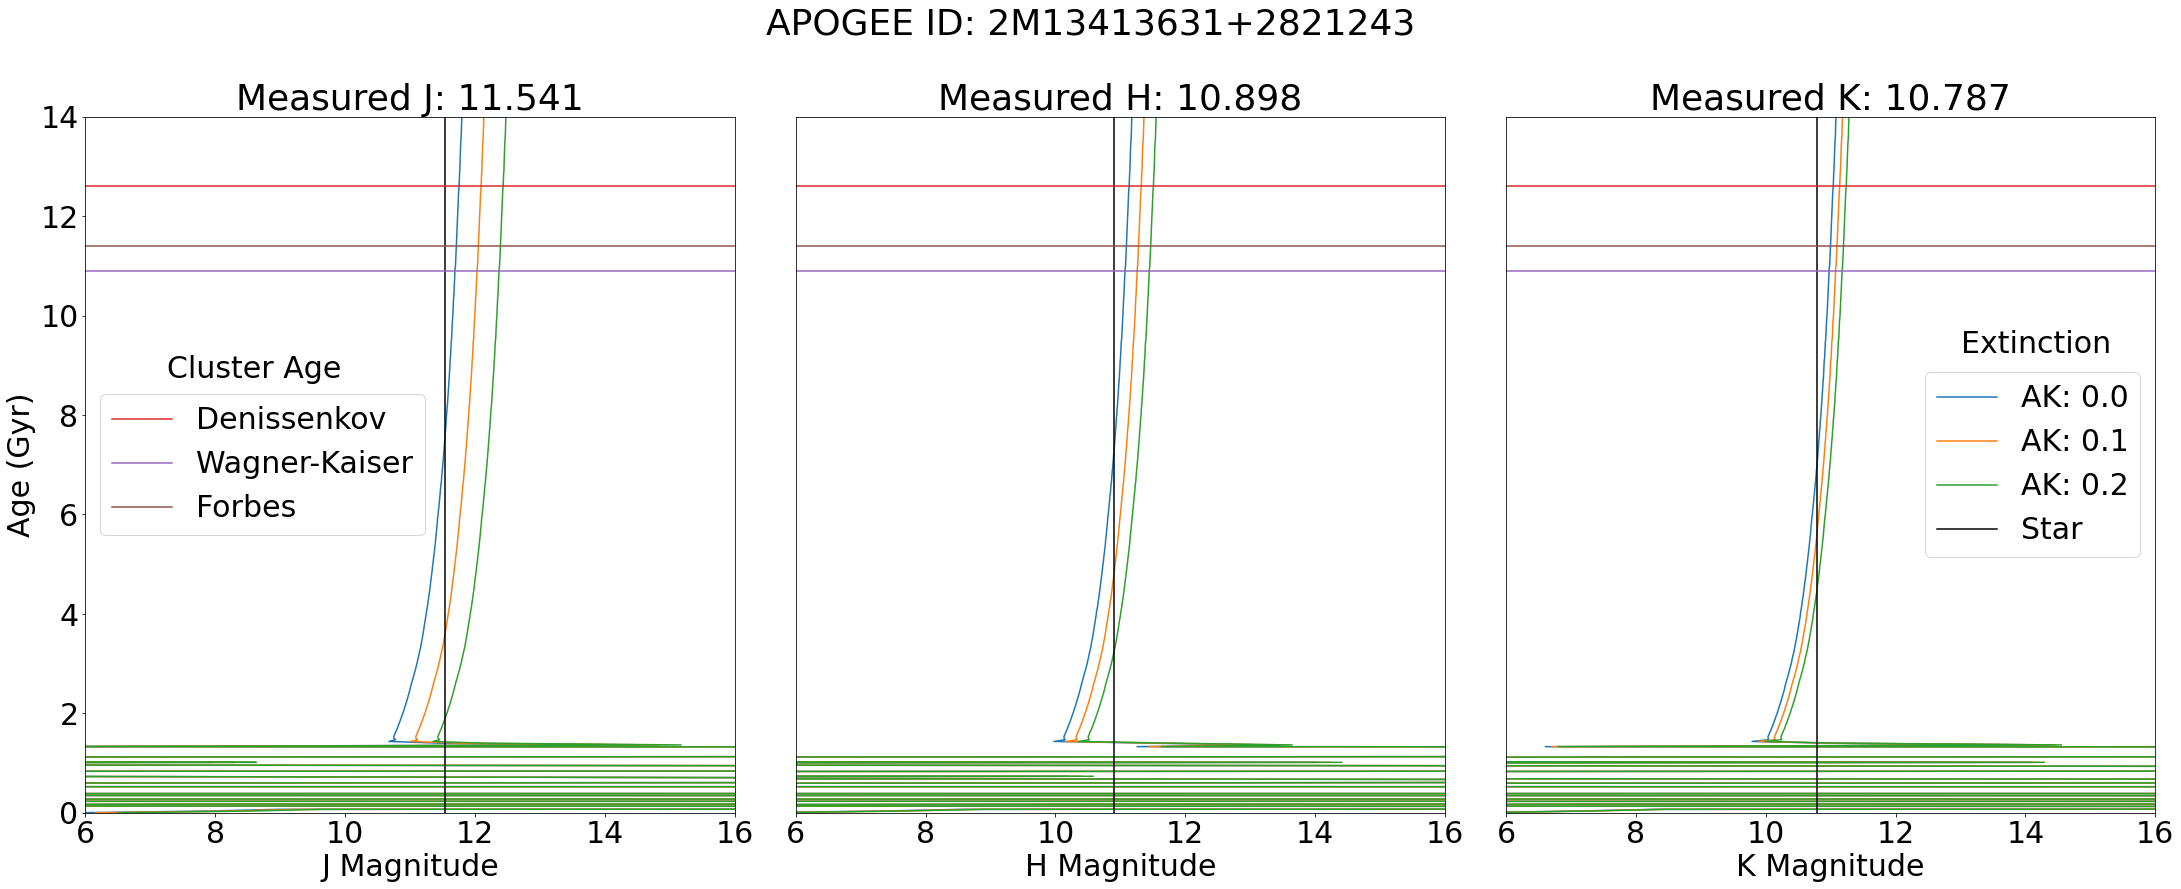

In [102]:
plt.figure(figsize=[31,12])

plt.subplot(131)
plt.plot(jmag_arr[:,0],age_grid)
plt.plot(jmag_arr[:,1],age_grid)
plt.plot(jmag_arr[:,2],age_grid)
plt.axvline(gcs['J'][g_idx],c='k')
plt.axhline(12.6,c='tab:red',label='Denissenkov')
plt.axhline(10.9,c='tab:purple',label='Wagner-Kaiser')
plt.axhline(11.39,c='tab:brown',label='Forbes')
plt.legend(loc = 'center left')
plt.ylim(0,14)
plt.xlim(6,16)
plt.title(r'Measured J: {:.3f}'.format(gcs['J'][g_idx]))
plt.xlabel(r'J Magnitude')
plt.ylabel(r'Age (Gyr)')

plt.text(7.25,8.75,'Cluster Age')

plt.subplot(132)
plt.gca().set_yticks([])
plt.plot(hmag_arr[:,0],age_grid)
plt.plot(hmag_arr[:,1],age_grid)
plt.plot(hmag_arr[:,2],age_grid)
plt.axvline(gcs['H'][g_idx],c='k')
plt.axhline(12.6,c='tab:red',label='Denissenkov')
plt.axhline(10.9,c='tab:purple',label='Wagner-Kaiser')
plt.axhline(11.39,c='tab:brown',label='Forbes')
plt.ylim(0,14)
plt.xlim(6,16)
plt.title(r'Measured H: {:.3f}'.format(gcs['H'][g_idx]))
plt.xlabel(r'H Magnitude')

plt.subplot(133)
plt.gca().set_yticks([])
plt.plot(kmag_arr[:,0],age_grid,label='AK: {}'.format(ak_grid[0]))
plt.plot(kmag_arr[:,1],age_grid,label='AK: {}'.format(ak_grid[1]))
plt.plot(kmag_arr[:,2],age_grid,label='AK: {}'.format(ak_grid[2]))
plt.axvline(gcs['K'][g_idx],c='k',label='Star')
plt.axhline(12.6,c='tab:red')
plt.axhline(10.9,c='tab:purple')
plt.axhline(11.39,c='tab:brown')
plt.legend()
plt.ylim(0,14)
plt.xlim(6,16)
plt.title(r'Measured K: {:.3f}'.format(gcs['K'][g_idx]))
plt.xlabel(r'K Magnitude')

plt.text(13.,9.25,'Extinction')

plt.suptitle(r'APOGEE ID: {}'.format(gcs['APOGEE_ID'][g_idx]),y=1.05)
plt.tight_layout()
plt.savefig('singlestar_agemag.pdf',bbox_inches='tight')
plt.show()

In [74]:
gcs['CLUSTER'][g_idx]

'M3'

In [37]:
np.arange(0.,14.,14./400.)

array([ 0.   ,  0.035,  0.07 ,  0.105,  0.14 ,  0.175,  0.21 ,  0.245,
        0.28 ,  0.315,  0.35 ,  0.385,  0.42 ,  0.455,  0.49 ,  0.525,
        0.56 ,  0.595,  0.63 ,  0.665,  0.7  ,  0.735,  0.77 ,  0.805,
        0.84 ,  0.875,  0.91 ,  0.945,  0.98 ,  1.015,  1.05 ,  1.085,
        1.12 ,  1.155,  1.19 ,  1.225,  1.26 ,  1.295,  1.33 ,  1.365,
        1.4  ,  1.435,  1.47 ,  1.505,  1.54 ,  1.575,  1.61 ,  1.645,
        1.68 ,  1.715,  1.75 ,  1.785,  1.82 ,  1.855,  1.89 ,  1.925,
        1.96 ,  1.995,  2.03 ,  2.065,  2.1  ,  2.135,  2.17 ,  2.205,
        2.24 ,  2.275,  2.31 ,  2.345,  2.38 ,  2.415,  2.45 ,  2.485,
        2.52 ,  2.555,  2.59 ,  2.625,  2.66 ,  2.695,  2.73 ,  2.765,
        2.8  ,  2.835,  2.87 ,  2.905,  2.94 ,  2.975,  3.01 ,  3.045,
        3.08 ,  3.115,  3.15 ,  3.185,  3.22 ,  3.255,  3.29 ,  3.325,
        3.36 ,  3.395,  3.43 ,  3.465,  3.5  ,  3.535,  3.57 ,  3.605,
        3.64 ,  3.675,  3.71 ,  3.745,  3.78 ,  3.815,  3.85 ,  3.885,
      

In [103]:
gcs.columns

<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX_JK','PARAM','FPARAM','PARAM_COV','FPARAM_COV','TEFF','TEFF_ERR','LOGG','LOGG_ERR','VMICRO','VMACRO','VSINI','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','ASPCAP_CHI

hello world
